# Installs & Imports

In [1]:
!pip install -q prophet ThymeBoost statsforecast dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.4 MB/s eta 0:00:00


In [2]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Suppress logging from Prophet and CmdStanPy
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
os.environ["CMDSTANPY_VERBOSITY"] = "error"

from prophet import Prophet
from ThymeBoost import ThymeBoost as tb
from statsforecast.models import AutoMFLES

# Data Loading

In [3]:
def load_data(url):
    df = pd.read_csv(url)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

# Load the data
data_url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
df = load_data(data_url)
df.head(10)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
5,2007-12-15,7.783641
6,2007-12-16,8.414052
7,2007-12-17,8.829226
8,2007-12-18,8.382518
9,2007-12-19,8.069655


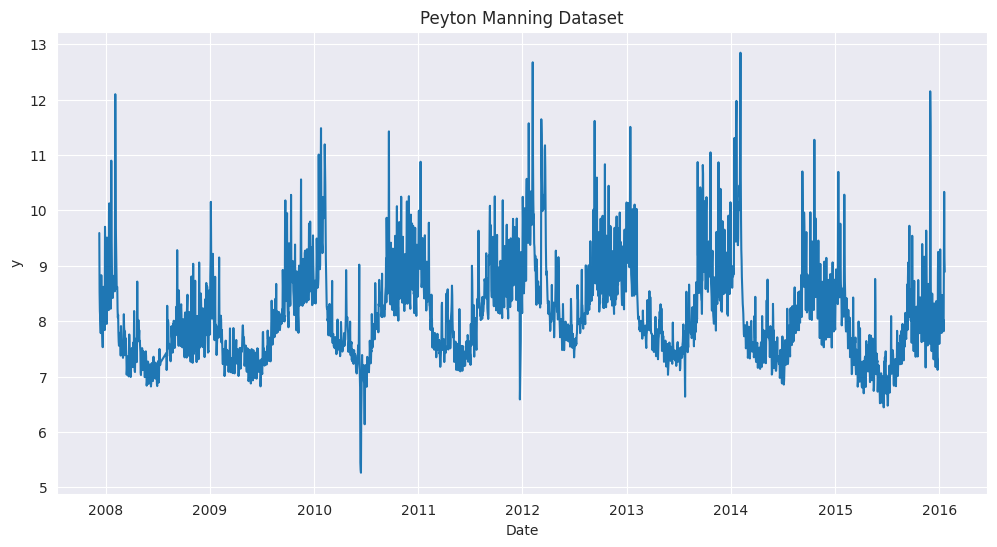

In [4]:
def visualize_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], markersize=1, linestyle='-')  # plot the time series data
    plt.title('Peyton Manning Dataset')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.show()

# Visualize the loaded data
visualize_data(df)

In [5]:
# Dataset info
print("Dataset Information:")
print(df.info())
print("\nSummary Statistics:")
display(df['y'].describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2905 non-null   datetime64[ns]
 1   y       2905 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.5 KB
None

Summary Statistics:


,y
count,2905.000000
mean,8.138958
std,0.845957
min,5.262690
25%,7.514800
50%,7.997999
75%,8.580168
max,12.846747


# Data Preparation

In [6]:
# def split_data(df, out_sample):
#     df = df.sort_values('ds').reset_index(drop=True)
#     train_df = df.iloc[:-out_sample].copy()
#     test_df  = df.iloc[-out_sample:].copy()
#     return train_df, test_df

# # Set out_sample for splitting
# out_sample = 2 * 365
# train_df, test_df = split_data(df, out_sample)

# print("Training period:", train_df['ds'].min(), "to", train_df['ds'].max())
# print("Test period:", test_df['ds'].min(), "to", test_df['ds'].max())

# # Use the test set's dates as the forecast index
# test_dates = test_df['ds'].reset_index(drop=True)
# print("Length of test_dates:", len(test_dates))

In [7]:
def split_data_by_date(df, split_date):
    """
    Split the data using a specific split_date. All rows with ds < split_date go into train_df,
    and rows with ds >= split_date go into test_df.
    """
    df = df.sort_values('ds').reset_index(drop=True)
    train_df = df[df['ds'] < split_date].copy()
    test_df  = df[df['ds'] >= split_date].copy()
    return train_df, test_df

# Specify the split date
split_date = pd.to_datetime('2014-01-18')
train_df, test_df = split_data_by_date(df, split_date)

print("Training period:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Test period:", test_df['ds'].min(), "to", test_df['ds'].max())

# Use the test set's ds column as the forecast index
test_dates = test_df['ds'].reset_index(drop=True)
print("Length of test_dates:", len(test_dates))

Training period: 2007-12-10 00:00:00 to 2014-01-17 00:00:00
Test period: 2014-01-18 00:00:00 to 2016-01-20 00:00:00
Length of test_dates: 730


# Model Fitting

## Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwh1iqx9/2fh65gyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwh1iqx9/tbey1b6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8538', 'data', 'file=/tmp/tmpcwh1iqx9/2fh65gyv.json', 'init=/tmp/tmpcwh1iqx9/tbey1b6n.json', 'output', 'file=/tmp/tmpcwh1iqx9/prophet_modelc7z7wms4/prophet_model-20250207040612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:06:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


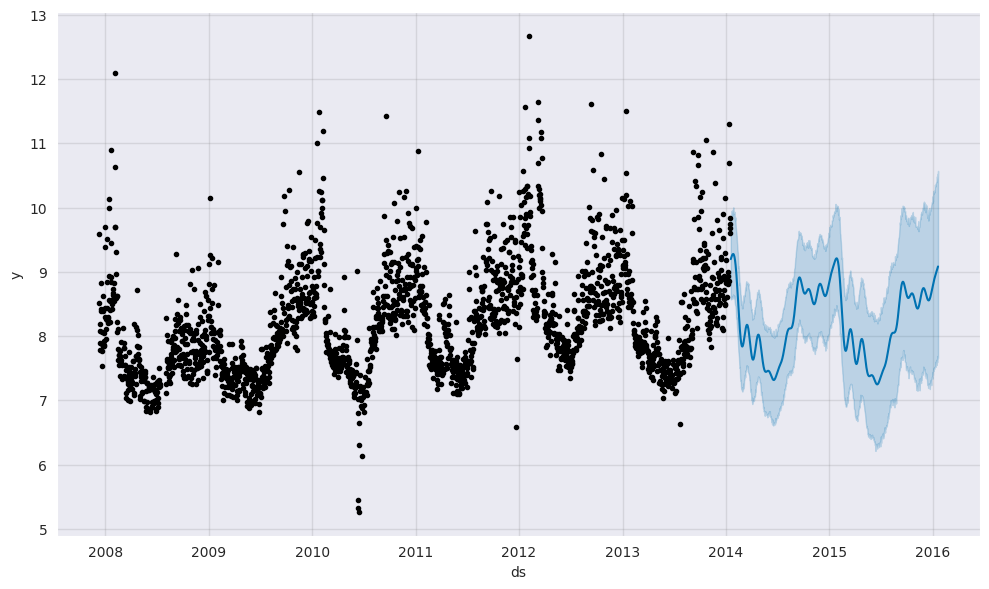

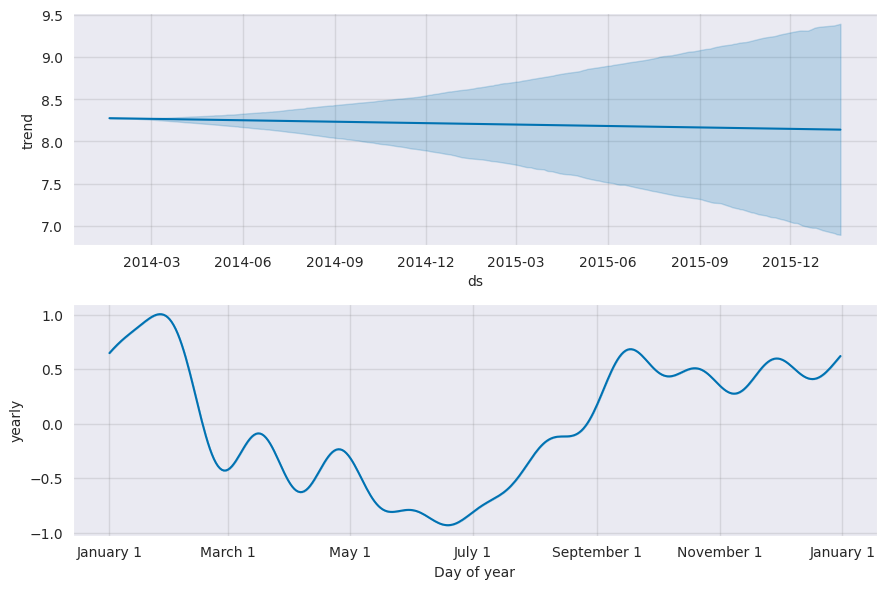

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.197149,8.575775,9.823882
1,2014-01-19,9.211259,8.571252,9.859259
2,2014-01-20,9.224869,8.578421,9.860222
3,2014-01-21,9.237705,8.608427,9.951149
4,2014-01-22,9.249439,8.582696,9.933410


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,9.025778,7.641156,10.486439
726,2016-01-17,9.040325,7.592352,10.397888
727,2016-01-18,9.054801,7.690540,10.523927
728,2016-01-19,9.069076,7.650887,10.434440
729,2016-01-20,9.082967,7.661841,10.571003


In [8]:
def fit_prophet(train_df, test_dates):
    model = Prophet(weekly_seasonality=False)
    model.fit(train_df)

    future = pd.DataFrame({'ds': test_dates})
    forecast = model.predict(future)

    # Plot the forecast
    model.plot(forecast)
    model.plot_components(forecast)
    plt.show()

    # Select only the forecast rows whose ds values are in test_dates
    prophet_forecast = forecast[forecast['ds'].isin(test_dates)].copy()
    prophet_forecast = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)

    return prophet_forecast

# Fit Prophet
prophet_forecast = fit_prophet(train_df, test_dates)
print("\n")
display(prophet_forecast.head())
print("\n")
display(prophet_forecast.tail())

## ThymeBoost

In [9]:
def bootstrap_intervals(forecast, residuals, n_bootstrap=1000, alpha=0.05):
    """
    Generate bootstrap forecast samples by randomly adding sampled residuals
    Returns lower and upper prediction intervals
    """
    n_forecast = len(forecast)
    boot_samples = np.zeros((n_bootstrap, n_forecast))

    for i in range(n_bootstrap):
        sampled_resids = np.random.choice(residuals, size=n_forecast, replace=True)
        boot_samples[i, :] = forecast + sampled_resids

    lower = np.percentile(boot_samples, 100 * alpha / 2, axis=0)
    upper = np.percentile(boot_samples, 100 * (1 - alpha / 2), axis=0)

    return lower, upper

In [10]:
def fit_thymeboost(train_df, test_dates, n_bootstrap=1000, alpha=0.05):
    model = tb.ThymeBoost(verbose=1, n_rounds=None)
    output = model.fit(train_df['y'].values,
                       seasonal_period=[365],
                       trend_estimator=['lbf'],
                       n_changepoints=25)

    horizon = len(test_dates)
    predicted_output = model.predict(output, horizon, trend_penalty=True)
    preds = predicted_output['predictions']

    # Create residuals using a naive lag-1 forecast as a proxy for in-sample predictions
    naive_preds = train_df['y'].shift(1)
    residuals = (train_df['y'] - naive_preds).dropna().values
    lower, upper = bootstrap_intervals(preds, residuals, n_bootstrap=n_bootstrap, alpha=alpha)

    thymeboost_df = pd.DataFrame({
        'ds': test_dates.to_numpy(),  # Convert to NumPy array to resolve indexing error
        'yhat': preds,
        'yhat_lower': lower,
        'yhat_upper': upper
    }).reset_index(drop=True)

    return thymeboost_df

# Fit ThymeBoost
thymeboost_forecast = fit_thymeboost(train_df, test_dates)
print("\n")
display(thymeboost_forecast.head())
print("\n")
display(thymeboost_forecast.tail())

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
fourier(10, False)
cost: -1760.6189770706765
********** Round 2 **********
Using Split: None
Fitting global with trend model:
lbf(25)
seasonal model:
fourier(10, False)
cost: -2515.4563208265886
Boosting Terminated 
Using round 2




,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.172550,8.155383,10.264065
1,2014-01-19,9.178097,8.147710,10.240260
2,2014-01-20,9.182399,8.165558,10.226136
3,2014-01-21,9.185518,8.270701,10.260601
4,2014-01-22,9.187508,8.047950,10.271653


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,9.111437,8.142304,10.334999
726,2016-01-17,9.124173,8.118126,10.305930
727,2016-01-18,9.135404,8.173960,10.178999
728,2016-01-19,9.145154,8.114657,10.326789
729,2016-01-20,9.153468,8.102432,10.253940


## AutoMFLES

In [11]:
def fit_automfles(train_df, test_dates, n_bootstrap=1000, alpha=0.05):
    horizon = len(test_dates)
    y_train = train_df['y'].values

    model = AutoMFLES(
        season_length=[365],
        test_size=horizon,
        n_windows=2,
        metric='smape'
    )
    model.fit(y=y_train)

    forecast = model.predict(horizon)
    preds = forecast['mean']

    # Compute in-sample residuals from fitted values
    fitted = model.predict_in_sample()['fitted']
    residuals = train_df['y'].values - fitted
    lower, upper = bootstrap_intervals(preds, residuals, n_bootstrap=n_bootstrap, alpha=alpha)

    automfles_df = pd.DataFrame({
        'ds': test_dates,
        'yhat': preds,
        'yhat_lower': lower,
        'yhat_upper': upper
    }).reset_index(drop=True)

    return automfles_df

# Fit AutoMFLES
automfles_forecast = fit_automfles(train_df, test_dates)
display(automfles_forecast.head())
print("\n")
display(automfles_forecast.tail())

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.335735,8.419145,10.909636
1,2014-01-19,9.323011,8.408183,10.781861
2,2014-01-20,9.310002,8.393413,10.611048
3,2014-01-21,9.297600,8.415847,10.525730
4,2014-01-22,9.286571,8.333302,10.454314


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,9.395371,8.512738,10.813750
726,2016-01-17,9.398726,8.493228,10.546754
727,2016-01-18,9.397019,8.544085,10.749699
728,2016-01-19,9.391079,8.511004,10.529959
729,2016-01-20,9.381851,8.487032,10.769446


# Metrics Evaluation

In [12]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

def mae(y, y_pred):
    return np.mean(np.abs(y - y_pred))

def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / np.where(y == 0, 1e-8, y))) * 100

def smape(y, y_pred):
    return 100 / len(y) * np.sum(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred) + 1e-8))

def wmape(y, y_pred):
    return 100 * np.sum(np.abs(y - y_pred)) / (np.sum(np.abs(y)) + 1e-8)

In [13]:
def compute_model_metrics(eval_df, model_label):
    y_true = eval_df['y'].values
    y_pred = eval_df['yhat'].values
    return {
        'Model': model_label,
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'sMAPE': smape(y_true, y_pred),
        'wMAPE': wmape(y_true, y_pred)
    }

In [14]:
# Prepare an evaluation dataframe from the test set
eval_df = test_df[['ds', 'y']].reset_index(drop=True)
eval_df.head()

,ds,y
0,2014-01-18,9.434683
1,2014-01-19,11.503622
2,2014-01-20,11.976779
3,2014-01-21,10.542574
4,2014-01-22,10.004283


In [15]:
# Normalize ds columns so that they match exactly
eval_df['ds'] = pd.to_datetime(eval_df['ds']).dt.normalize()
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds']).dt.normalize()
thymeboost_forecast['ds'] = pd.to_datetime(thymeboost_forecast['ds']).dt.normalize()
automfles_forecast['ds'] = pd.to_datetime(automfles_forecast['ds']).dt.normalize()

In [16]:
# Debug prints: check the ds datatypes
print("Test df 'ds' dtype:", test_df['ds'].dtype)
print("Prophet forecast 'ds' dtype:", prophet_forecast['ds'].dtype)
print("ThymeBoost forecast 'ds' dtype:", thymeboost_forecast['ds'].dtype)
print("AutoMFLES forecast 'ds' dtype:", automfles_forecast['ds'].dtype)

Test df 'ds' dtype: datetime64[ns]
Prophet forecast 'ds' dtype: datetime64[ns]
ThymeBoost forecast 'ds' dtype: datetime64[ns]
AutoMFLES forecast 'ds' dtype: datetime64[ns]


In [17]:
# Debug prints: check the ds lengths
print("Test set ds length:", len(eval_df['ds']))
print("Prophet forecast ds length:", len(prophet_forecast['ds']))
print("ThymeBoost forecast ds length:", len(thymeboost_forecast['ds']))
print("AutoMFLES forecast ds length:", len(automfles_forecast['ds']))

Test set ds length: 730
Prophet forecast ds length: 730
ThymeBoost forecast ds length: 730
AutoMFLES forecast ds length: 730


In [18]:
# Debug prints: check the ds ranges
print("Test set ds range:", eval_df['ds'].min(), "to", eval_df['ds'].max())
print("Prophet forecast ds range:", prophet_forecast['ds'].min(), "to", prophet_forecast['ds'].max())
print("ThymeBoost forecast ds range:", thymeboost_forecast['ds'].min(), "to", thymeboost_forecast['ds'].max())
print("AutoMFLES forecast ds range:", automfles_forecast['ds'].min(), "to", automfles_forecast['ds'].max())

Test set ds range: 2014-01-18 00:00:00 to 2016-01-20 00:00:00
Prophet forecast ds range: 2014-01-18 00:00:00 to 2016-01-20 00:00:00
ThymeBoost forecast ds range: 2014-01-18 00:00:00 to 2016-01-20 00:00:00
AutoMFLES forecast ds range: 2014-01-18 00:00:00 to 2016-01-20 00:00:00


In [19]:
# Merge each model's point forecasts with the evaluation data
prophet_eval = eval_df.merge(prophet_forecast[['ds', 'yhat']], on='ds', how='left')
thymeboost_eval = eval_df.merge(thymeboost_forecast[['ds', 'yhat']], on='ds', how='left')
automfles_eval = eval_df.merge(automfles_forecast[['ds', 'yhat']], on='ds', how='left')

In [20]:
# Compute metrics for each model
metrics = []
metrics.append(compute_model_metrics(prophet_eval, 'Prophet'))
metrics.append(compute_model_metrics(thymeboost_eval, 'ThymeBoost'))
metrics.append(compute_model_metrics(automfles_eval, 'AutoMFLES'))

metrics_df = pd.DataFrame(metrics)
print("Forecast Error Metrics:")
display(metrics_df)

Forecast Error Metrics:


,Model,RMSE,MAE,MAPE,sMAPE,wMAPE
0,Prophet,0.633699,0.493199,6.170080,6.029446,6.212273
1,ThymeBoost,0.727946,0.595381,7.528726,7.273051,7.499333
2,AutoMFLES,0.789791,0.667551,8.491962,8.131229,8.408374


# Forecast Plotting

In [21]:
def plot_model_forecast(eval_df, forecast_df, model_label, ax):
    ax.plot(eval_df['ds'], eval_df['y'], label='Actual', color='black')
    ax.plot(forecast_df['ds'], forecast_df['yhat'], label='Predicted')
    ax.fill_between(forecast_df['ds'],
                    forecast_df['yhat_lower'],
                    forecast_df['yhat_upper'],
                    alpha=0.2, label='Prediction Interval')
    ax.set_title(f'{model_label} Forecast vs. Actual')
    ax.legend()

In [22]:
def plot_all_forecasts(eval_df, prophet_df, thymeboost_df, automfles_df):
    fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    plot_model_forecast(eval_df, prophet_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 'Prophet', axs[0])
    plot_model_forecast(eval_df, thymeboost_df, 'ThymeBoost', axs[1])
    plot_model_forecast(eval_df, automfles_df, 'AutoMFLES', axs[2])
    axs[2].set_xlabel('Date')
    plt.show()

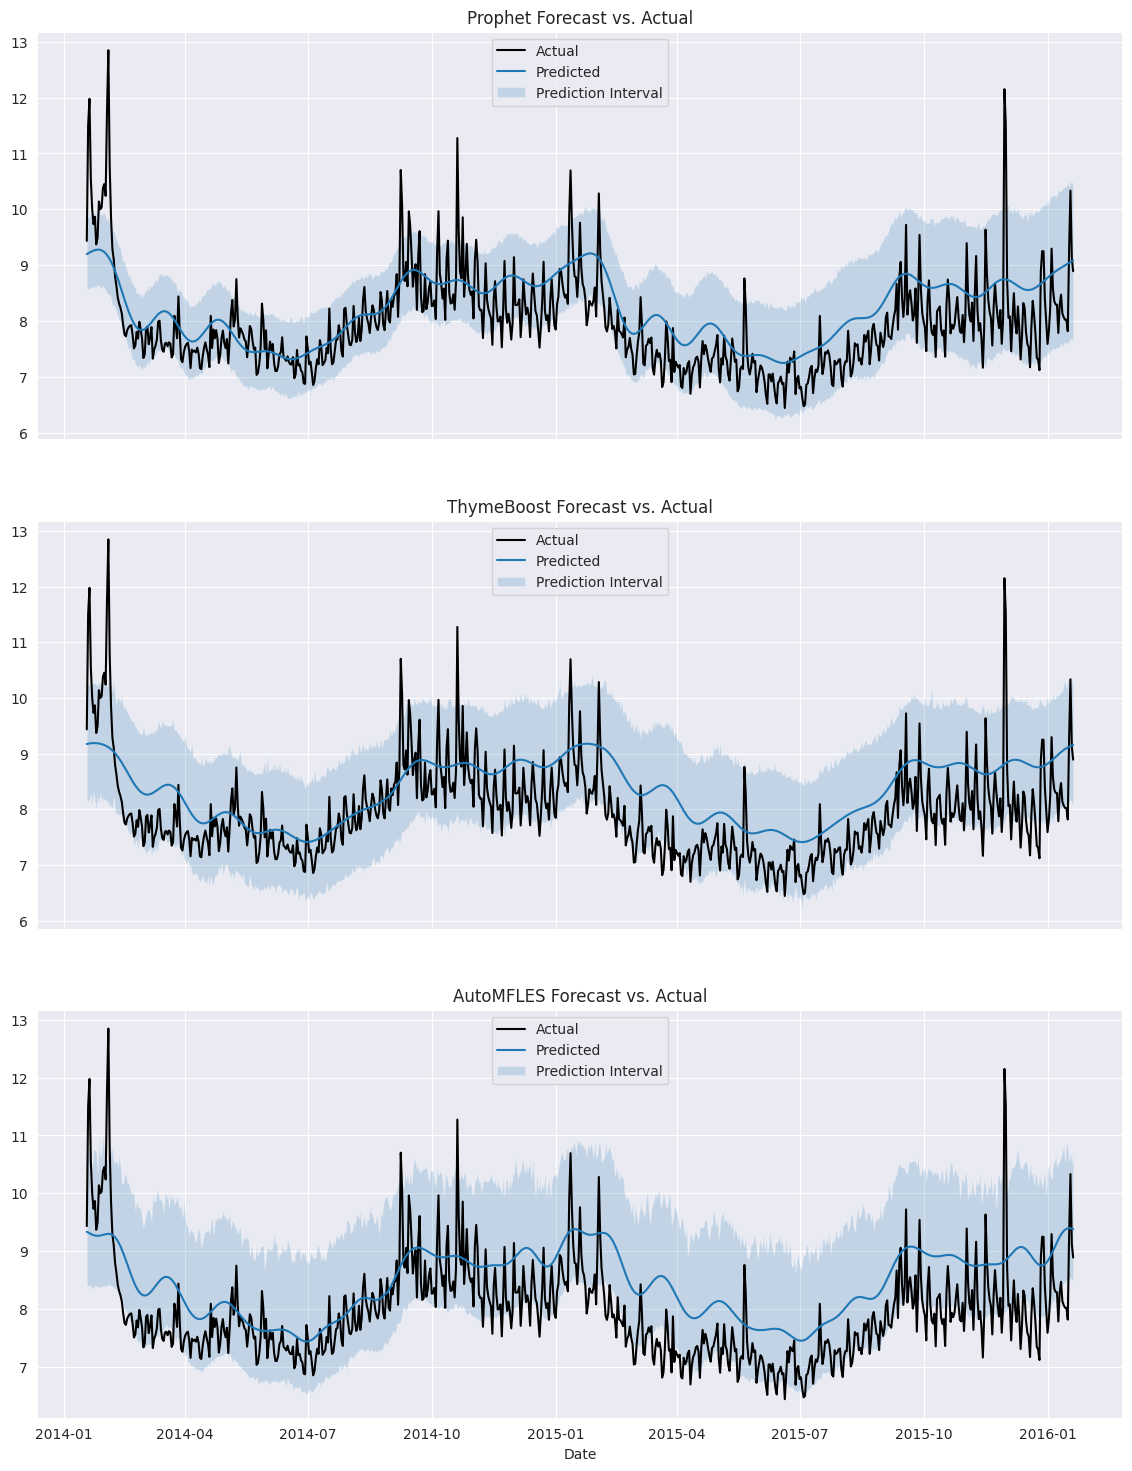

In [23]:
# Plot all forecasts versus the actual test data
plot_all_forecasts(
    eval_df,
    prophet_forecast,
    thymeboost_forecast,
    automfles_forecast
)